In [ ]:
# Imported Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

In [62]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [63]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [64]:
# Show column names
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## Data Cleaning

We start by checking for missing values.

In [65]:
# Check for Null Values!
df.isnull().sum().max()

0

Text(0.5, 1.0, 'Class Distributions')

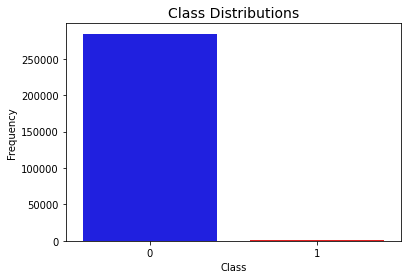

In [66]:
# Visualize the distribution of the transacton types
color = ["blue", "red"]
sns.countplot(x='Class', data=df, palette = color)
plt.ylabel('Frequency')
plt.title('Class Distributions', fontsize=14)

This plot shows us that the dataset is largely unbalanced. This will make the model to be biased towards 0 (non-fraudulent transactions)

In [67]:
# The classes are heavily skewed
print('Non-Fraudulent:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraudulent:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Non-Fraudulent: 99.83 % of the dataset
Fraudulent: 0.17 % of the dataset


Next, we scale the Amount and Time column since those are the only columns that aren't scaled in our dataset. We can see this from the describe table below.
Another reason we need to scale is because we will be using some distance based algorithms to perform classification.

In [68]:
# Extract statistical details of the data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


We use RobustScaler to perform the scaling which is less prone to outliers because it uses the median and Inter Quartile Range (IQR) to scale the values.

In [69]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
# We use RobustScaler that's less prone to Outliers
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [70]:
# Every column is Scaled!
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


Now, we perform cross validation on the main (unbalanced) dataset to bring out test values that won't be affected by the undersampling. 

StratifiedkFold ensures they maintain the class proportion (99.83 : 0.17) in each of the folds.

In [71]:
from sklearn.model_selection import StratifiedKFold

print('Non-Fraudulent:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraudulent:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

ss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in ss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We would still get X_train and y_train for the undersample data that's why we are using original to distinguish.

# Check the Distribution of the labels
# Turn them into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print("Train Distribution:", train_counts_label/ len(original_ytrain))
print("Test Distribution:", test_counts_label/ len(original_ytest))

Non-Fraudulent: 99.83 % of the dataset
Fraudulent: 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

Train Distribution: [0.99827076 0.00172924]
Test Distribution: [0.99827952 0.00172048]


### UnderSampling

In [72]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Since the classes are highly skewed towards the non-fraudulent transactions, we use undersampling to make them equal.

In [73]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.
# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# Amount of fraud classes 492 rows.
fraud = df.loc[df['Class'] == 1]
non_fraud = df.loc[df['Class'] == 0][:492]

sub_sampled_df = pd.concat([fraud, non_fraud])

# Shuffle dataframe rows
new_df = sub_sampled_df.sample(frac=1, random_state=4)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
91812,0.795576,-1.205089,1.170927,0.756370,-1.663166,0.058313,-0.714528,0.154281,1.683825,-0.562192,-1.291215,0.328485,-0.705638,-0.781435,-1.051192,-0.348640,0.422742,-0.333406,0.413957,0.267238,0.106860,0.276511,-0.276520,0.509336,0.304406,1.209297,-0.052752,0.044934,0,2.573604,-0.247360
263230,-0.146701,0.826189,-1.067665,-1.318511,1.680628,-0.748483,1.501685,-0.190824,-0.593787,-0.318024,0.359434,0.235253,-0.580121,0.954197,-0.714911,-0.353167,-0.764873,0.257210,0.264999,0.024161,0.285615,0.887114,-0.204911,0.262348,-0.272152,0.068430,0.376282,0.263747,0,-0.009642,0.894724
161524,-3.104559,-1.444605,1.683933,-0.591614,2.830382,-3.366057,-0.539229,-0.208777,-0.063627,-0.581179,-0.090406,0.752139,0.179480,0.030279,-0.827886,0.036635,-0.422419,-1.271594,-1.249852,-0.512494,-0.401958,-0.876041,-0.626939,1.012252,0.526626,0.113946,0.421166,-0.044790,0,-0.294977,0.347549
215512,-0.584233,0.444011,-0.424663,1.377674,0.501486,-1.119959,0.468384,0.113910,-0.637202,-0.244587,-1.162224,-0.221174,-0.572289,1.070536,0.952737,-1.756116,1.078396,0.035644,2.962208,0.291619,0.226104,0.510689,-0.117983,0.024267,-0.287193,0.152774,0.090209,0.020310,0,0.275554,0.650994
150665,-6.750509,5.367416,-10.054635,9.064478,-7.968118,-2.263798,-10.317566,4.237666,-5.324109,-11.092392,7.154083,-17.150405,-0.095399,-11.030110,-1.959055,-12.448562,-22.667905,-9.264609,1.982356,-0.081220,1.909032,-0.348740,0.425001,0.674909,-0.784208,-0.247422,1.159581,0.197818,1,2.622092,0.107661


Using frac=1 in df.sample returns the shuffled dataset completely.

In [74]:
df = df.sample(frac=1)
df.shape

(284807, 31)

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


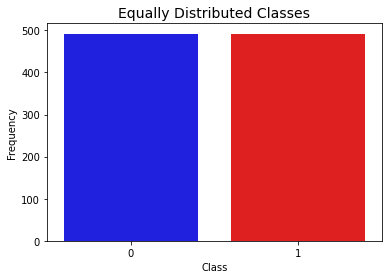

In [75]:
# Check Equal distribution
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot(x='Class', data=new_df, palette=color)
plt.ylabel('Frequency')
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Now we see that the dataset (new_df) is equally distributed amongst the classes.

Next, we check if any variable is strongly correlated with the Class column 

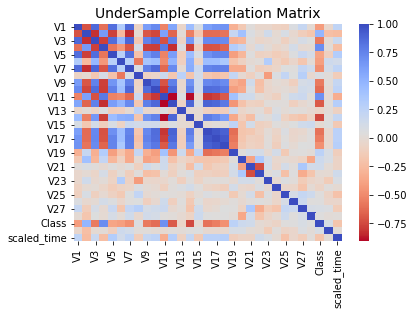

In [76]:
# Show correlation matrix for the subsample dataframe
sns.heatmap(new_df.corr(), cmap='coolwarm_r', annot_kws={'size':20})
plt.title('UnderSample Correlation Matrix', fontsize=14)
plt.show()

Negative Correlations: V16, V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.

Positive Correlations: V2, V4 and V11 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

## Data Modeling For Undersampling 

In [77]:
# Undersampling before cross validating
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Our data is already scaled we should split our training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [78]:
# We implement four classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [79]:
# Now, we calculate the cross validation score with each classifier.
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "has a training score of", round(training_score.mean(), 2) * 100, "% accuracy")

Classifiers:  LogisticRegression has a training score of 95.0 % accuracy
Classifiers:  KNeighborsClassifier has a training score of 94.0 % accuracy
Classifiers:  SVC has a training score of 94.0 % accuracy
Classifiers:  RandomForestClassifier has a training score of 95.0 % accuracy


We can see that Logistic Regression has the best cross_val_score, now we use GridSearchCV to find the best parameters for each classifier.

In [80]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100]}


grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# RandomForest Classifier
rf_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1)), "min_samples_split": list(range(2,5,1))}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_train, y_train)

# RF best estimator
rf_clf = grid_rf.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [81]:
# We calculate the cross validation scores using the best parameters

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score:', round(log_reg_score.mean() * 100, 2), '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score:', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score:', round(svc_score.mean() * 100, 2).astype(str) + '%')

rf_score = cross_val_score(rf_clf, X_train, y_train, cv=5)
print('RandomForest Classifier Cross Validation Score:', round(rf_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score: 95.5 %
Knears Neighbors Cross Validation Score: 94.48%
Support Vector Classifier Cross Validation Score: 95.35%
RandomForest Classifier Cross Validation Score: 93.75%


After using the best parameters, we still see that Logistic regression has the best cross_val_score.

In [82]:
# GridSearchCV is used to determine the paremeters that gives the best predictive score for the classifiers.
# Logistic Regression has the best Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates fraud and non-fraud transactions.

In [83]:
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

rf_pred = cross_val_predict(rf_clf, X_train, y_train, cv=5)

In [84]:
# Calculate ROC scores
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, rf_pred))

Logistic Regression:  0.9794173607881275
KNears Neighbors:  0.9433596888080843
Support Vector Classifier:  0.9728045325779038
Random Forest Classifier:  0.9389581835863177


We observe that Logistic Regression has the best cross_val_score and a very high Receiving Operating Characteristic score (ROC), meaning that LogisticRegression pretty accurately separates fraud and non-fraud transactions.

So we would use the Logistic Regression Model when oversampling.

## SMOTE Technique (Over-Sampling)

Synthetic Minority Oversampling Technique (SMOTE) synthesizes new examples from the minority class to make the dataset balanced.

We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. The formulars of Accuracy, Precision and Recall are given below:
*   Accuracy = (TP+TN)/total
*   Precision = TP/(TP+FP)
*   Recall = TP/(TP+FN)

In [85]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority', random_state=42)

# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)

In [86]:
# Logistic Regression
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=0.1)

### SMOTE Confusion Matrix

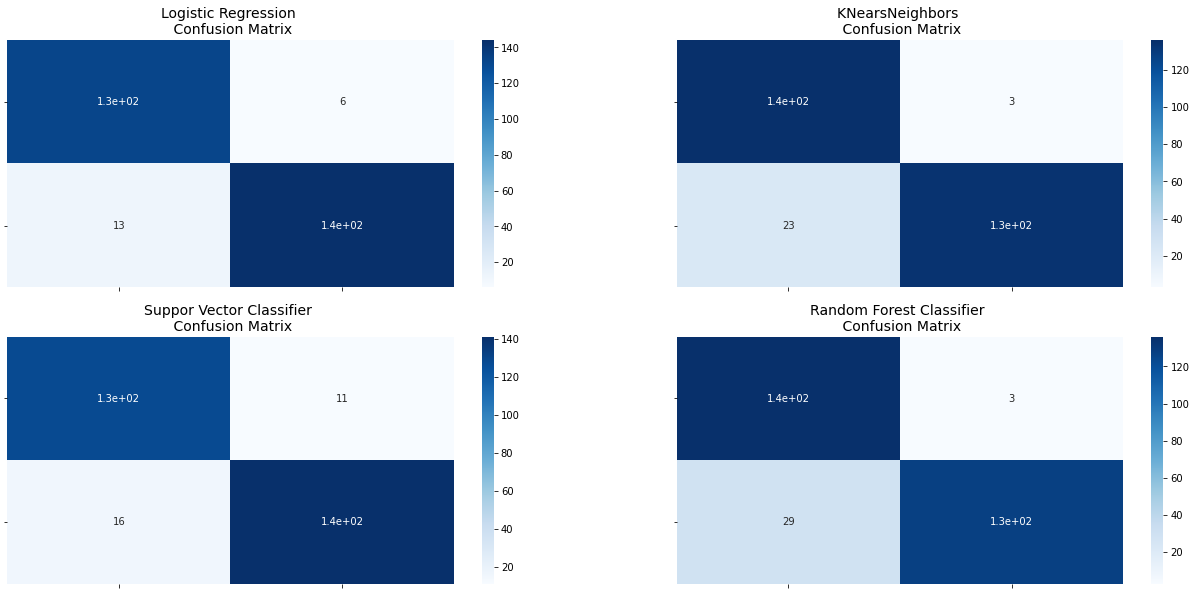

In [87]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
rf_cf = confusion_matrix(y_test, y_pred_rf)


fig, ax = plt.subplots(2, 2,figsize=(22,10))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.Blues)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.Blues)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.Blues)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(rf_cf, ax=ax[1][1], annot=True, cmap=plt.cm.Blues)
ax[1][1].set_title("Random Forest Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [88]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Random Forest Classifier:')
print(classification_report(y_test, y_pred_rf))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       139
           1       0.96      0.92      0.94       157

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       139
           1       0.98      0.85      0.91       157

    accuracy                           0.91       296
   macro avg       0.92      0.92      0.91       296
weighted avg       0.92      0.91      0.91       296

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       139
           1       0.93      0.90      0.91       157

    accuracy                           0.91       296
   macro avg       0.91      0.91      0.91       296
weighted

Observe that the logistic regression using SMOTE has a higher accuracy than other classifiers

In [89]:
# Final Score in the main test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = log_reg_sm.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

final_df

,Technique,Score
0,Random UnderSampling,0.935811
1,Oversampling (SMOTE),0.988343


## Neural Network (UnderSampling vs. OverSampling)

### UnderSampling

In [90]:
n_inputs = X_train.shape[1]

undersample_model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [91]:
undersample_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 30)                930       
                                                                 
 dense_10 (Dense)            (None, 32)                992       
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [92]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
undersample_model.compile(opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [93]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
22/22 - 1s - loss: 0.9242 - accuracy: 0.6782 - val_loss: 0.4729 - val_accuracy: 0.7609 - 577ms/epoch - 26ms/step
Epoch 2/20
22/22 - 0s - loss: 0.4121 - accuracy: 0.8545 - val_loss: 0.3364 - val_accuracy: 0.8623 - 60ms/epoch - 3ms/step
Epoch 3/20
22/22 - 0s - loss: 0.2983 - accuracy: 0.8982 - val_loss: 0.2830 - val_accuracy: 0.9130 - 61ms/epoch - 3ms/step
Epoch 4/20
22/22 - 0s - loss: 0.2369 - accuracy: 0.9327 - val_loss: 0.2473 - val_accuracy: 0.9275 - 83ms/epoch - 4ms/step
Epoch 5/20
22/22 - 0s - loss: 0.1954 - accuracy: 0.9400 - val_loss: 0.2185 - val_accuracy: 0.9348 - 59ms/epoch - 3ms/step
Epoch 6/20
22/22 - 0s - loss: 0.1626 - accuracy: 0.9491 - val_loss: 0.2039 - val_accuracy: 0.9275 - 67ms/epoch - 3ms/step
Epoch 7/20
22/22 - 0s - loss: 0.1406 - accuracy: 0.9545 - val_loss: 0.1917 - val_accuracy: 0.9348 - 73ms/epoch - 3ms/step
Epoch 8/20
22/22 - 0s - loss: 0.1239 - accuracy: 0.9582 - val_loss: 0.1891 - val_accuracy: 0.9275 - 69ms/epoch - 3ms/step
Epoch 9/20
22/22 - 0s 

#### Model Evaluation

In [94]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [95]:
predict_x = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)
undersample_fraud_predictions = np.argmax(predict_x,axis=1)

Text(0.5, 1.0, 'Confusion Matrix \n Of Original Test Set')

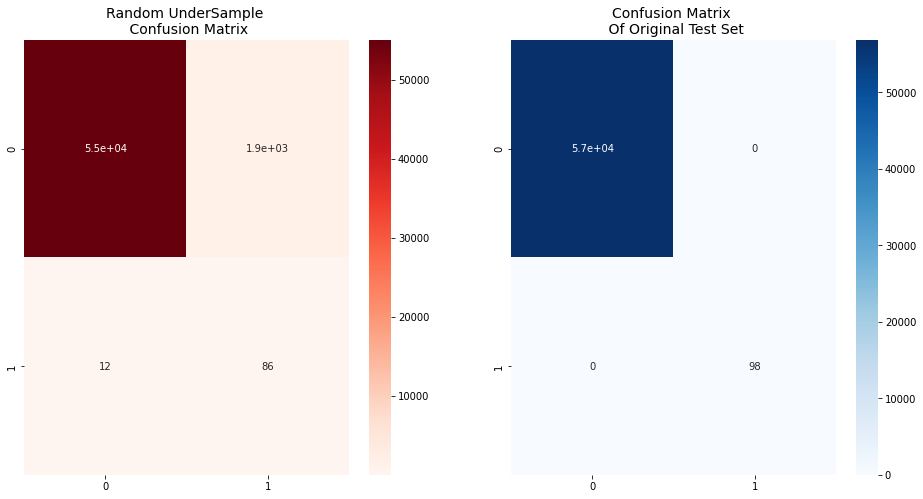

In [96]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

sns.heatmap(undersample_cm, ax=ax1, annot=True, cmap=plt.cm.Reds)
ax1.set_title("Random UnderSample \n Confusion Matrix", fontsize=14)

sns.heatmap(actual_cm, ax=ax2, annot=True, cmap=plt.cm.Blues)
ax2.set_title("Confusion Matrix \n Of Original Test Set", fontsize=14)

### OverSampling

In [97]:
n_inputs = Xsm_train.shape[1]

oversample_model = tf.keras.Sequential([
    tf.keras.layers.Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [98]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
oversample_model.compile(opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [99]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 3s - loss: 0.0577 - accuracy: 0.9797 - val_loss: 0.0216 - val_accuracy: 0.9974 - 3s/epoch - 2ms/step
Epoch 2/20
1214/1214 - 3s - loss: 0.0114 - accuracy: 0.9975 - val_loss: 0.0050 - val_accuracy: 0.9998 - 3s/epoch - 2ms/step
Epoch 3/20
1214/1214 - 2s - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.0036 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 4/20
1214/1214 - 2s - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.0038 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 5/20
1214/1214 - 2s - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9998 - 2s/epoch - 2ms/step
Epoch 6/20
1214/1214 - 3s - loss: 0.0030 - accuracy: 0.9993 - val_loss: 9.7116e-04 - val_accuracy: 1.0000 - 3s/epoch - 2ms/step
Epoch 7/20
1214/1214 - 2s - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0013 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoch 8/20
1214/1214 - 2s - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.0011 - val_accuracy: 1.0000 - 2s/epoch - 2ms/step
Epoc

#### Model Evaluation

In [100]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [101]:
predict_x2 = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
oversample_fraud_predictions = np.argmax(predict_x2,axis=1)

Text(0.5, 1.0, 'Confusion Matrix \n Of Original Test Set')

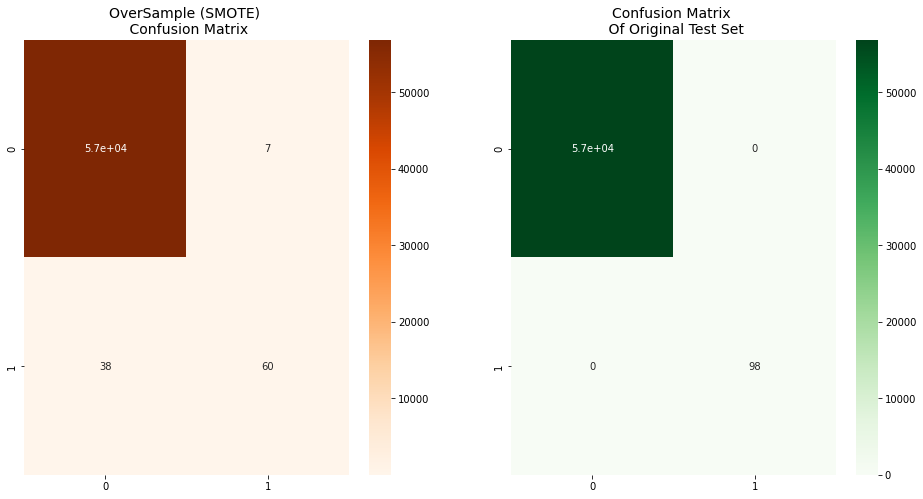

In [103]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 8))

sns.heatmap(oversample_smote, ax=ax1, annot=True, cmap=plt.cm.Oranges)
ax1.set_title("OverSample (SMOTE) \n Confusion Matrix", fontsize=14)

sns.heatmap(actual_cm, ax=ax2, annot=True, cmap=plt.cm.Greens)
ax2.set_title("Confusion Matrix \n Of Original Test Set", fontsize=14)

We can see that the Logistic Regression Model of the OverSampled Data did much better than the one applied to the UnderSampled Data. This could be because when undersampling there is loss of information which could have been used in model building.